In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import matplotlib
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [18]:
df = pd.read_csv('C:/Users/campus4D045/Desktop/data/bank.csv')
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [3]:
df.isnull().sum()
# VALUE 현재자산 14, JOB 직업 81, YOJ 대출 연차 205, DELINQ 신용한도 30,
# CLAGE 계좌 유지기간(월) 37, NINQ 최근 신용한도 56

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3748 entries, 0 to 3747
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3748 non-null   int64  
 1   LOAN     3748 non-null   int64  
 2   MORTDUE  3748 non-null   int64  
 3   VALUE    3734 non-null   float64
 4   REASON   3748 non-null   object 
 5   JOB      3667 non-null   object 
 6   YOJ      3543 non-null   float64
 7   DEROG    3748 non-null   int64  
 8   DELINQ   3718 non-null   float64
 9   CLAGE    3711 non-null   float64
 10  NINQ     3692 non-null   float64
 11  CLNO     3748 non-null   int64  
 12  DEBTINC  3748 non-null   float64
dtypes: float64(6), int64(5), object(2)
memory usage: 380.8+ KB


In [22]:
# VALUE 수치화
df['VALUE'] = pd.to_numeric(df['VALUE'], errors='coerce')

In [23]:
print(df['VALUE'].dtype)

float64


In [24]:
# YOJ 수치화
df['YOJ'] = pd.to_numeric(df['YOJ'], errors='coerce')

In [25]:
print(df['YOJ'].dtype)

float64


<Axes: >

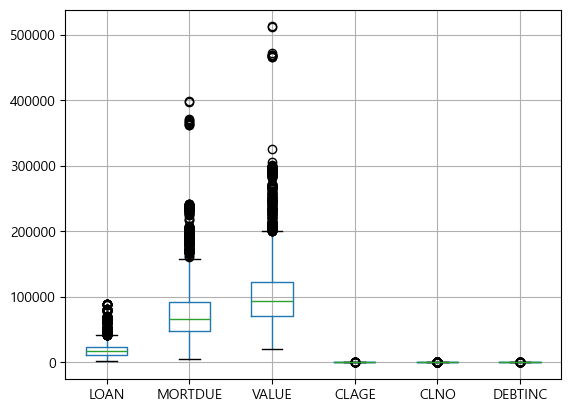

In [9]:
df.boxplot(['LOAN','MORTDUE','VALUE','CLAGE','CLNO','DEBTINC'])

<Axes: >

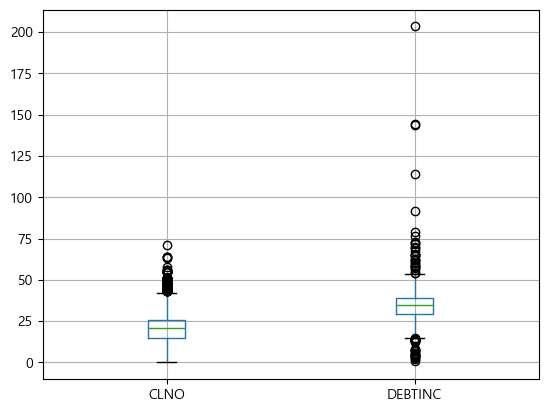

In [10]:
df.boxplot(['CLNO','DEBTINC'])

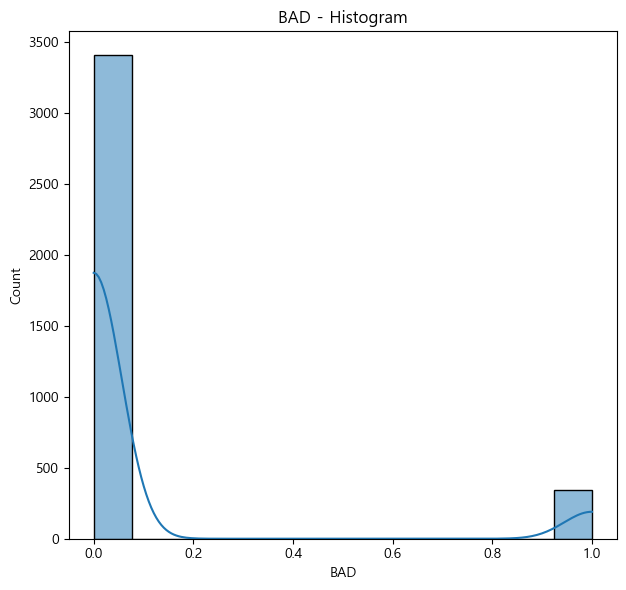

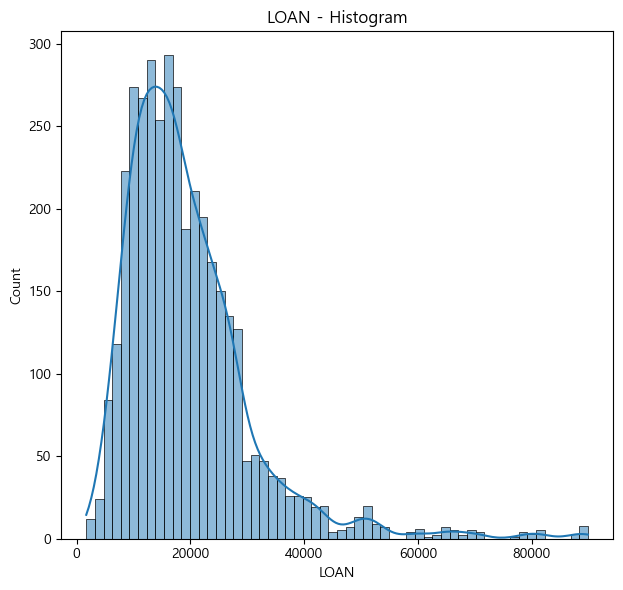

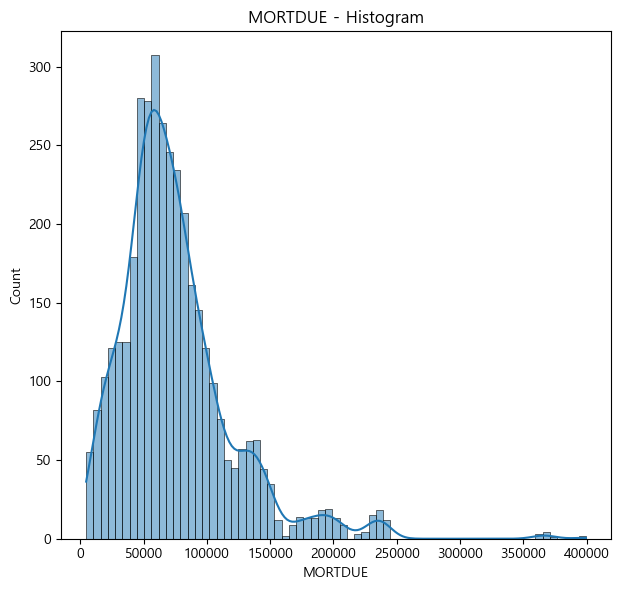

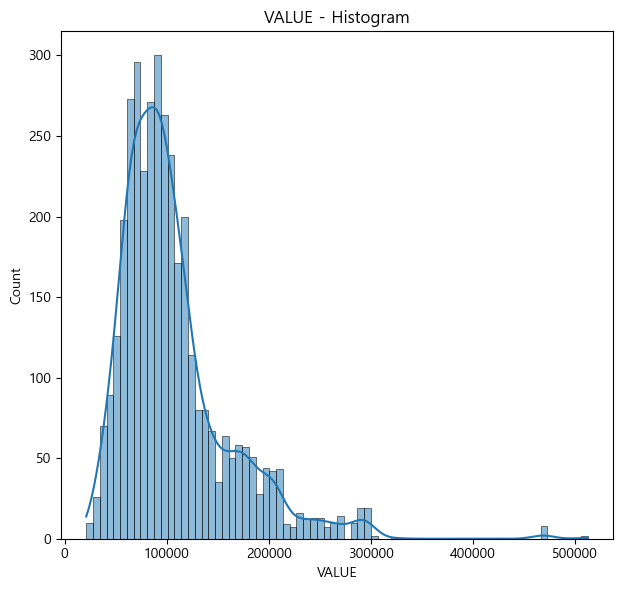

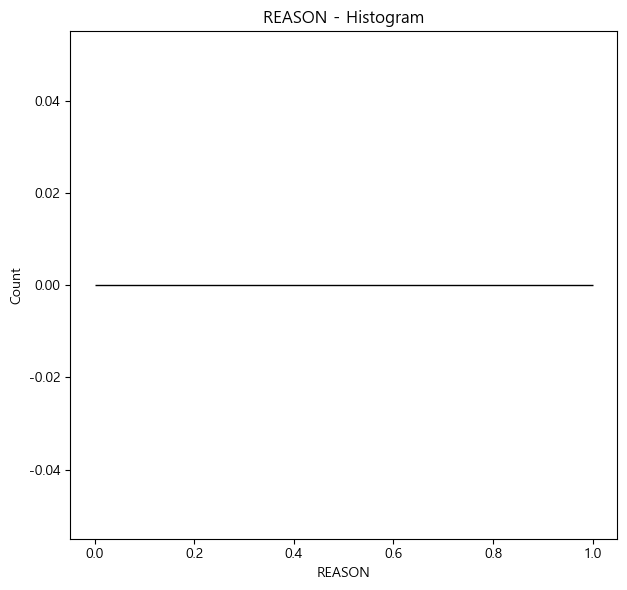

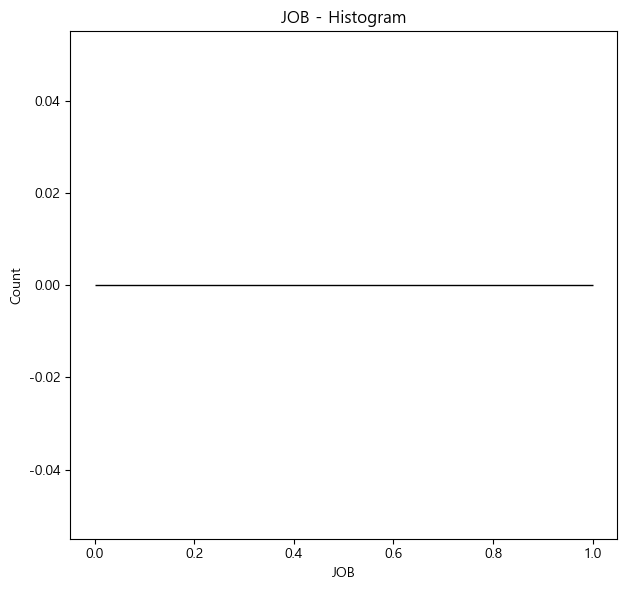

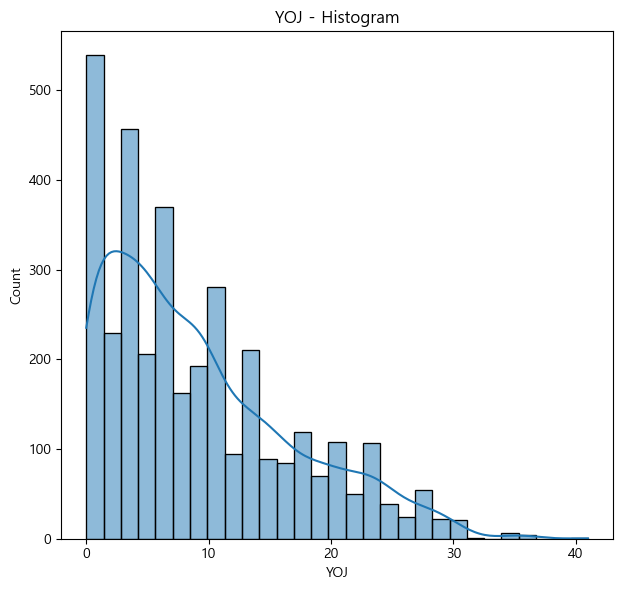

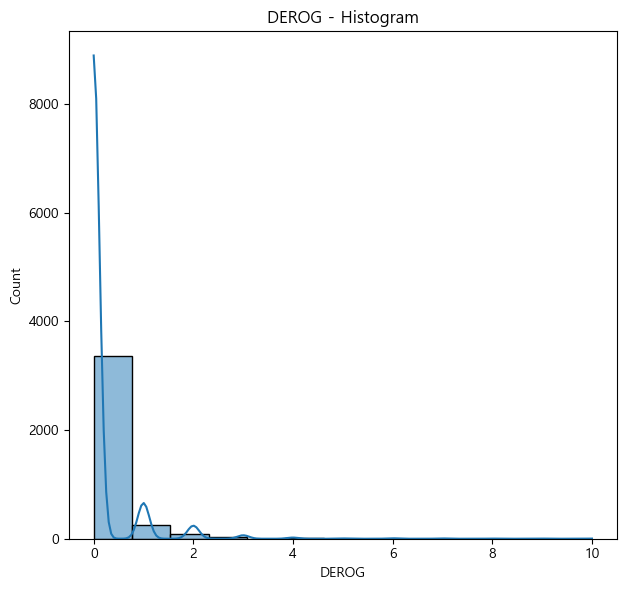

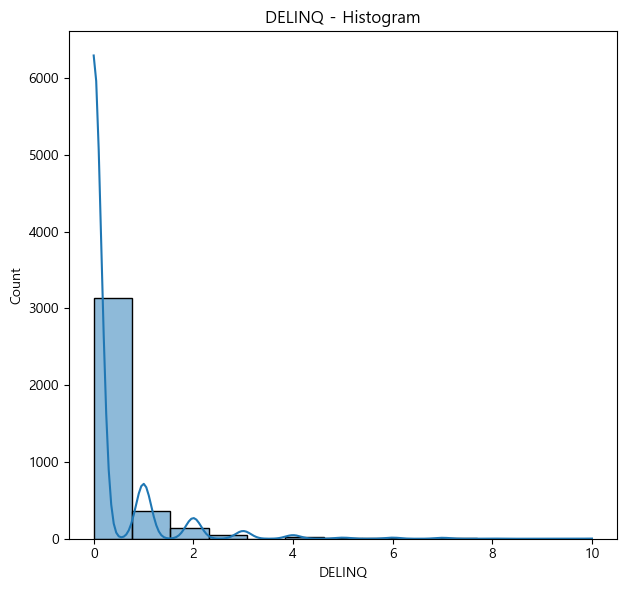

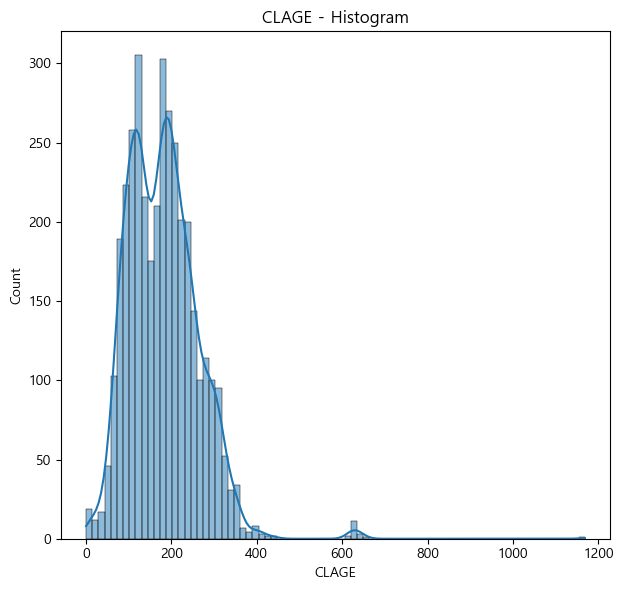

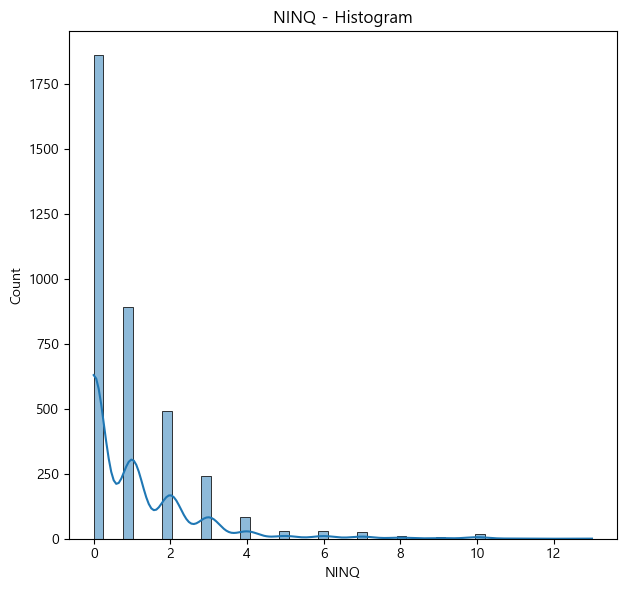

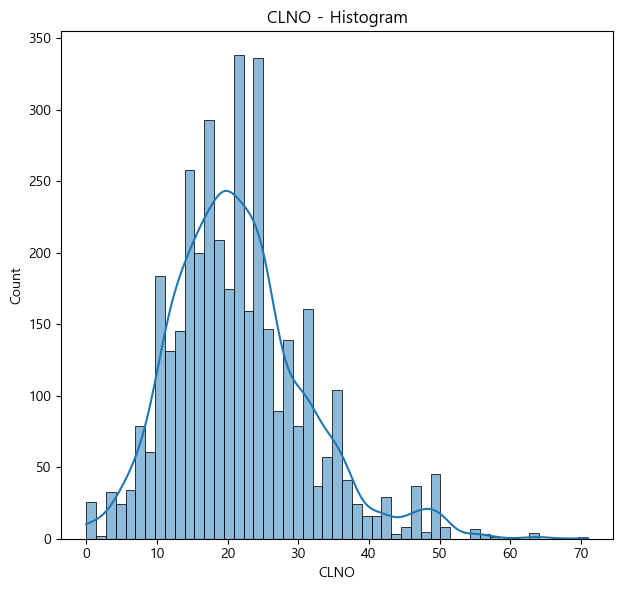

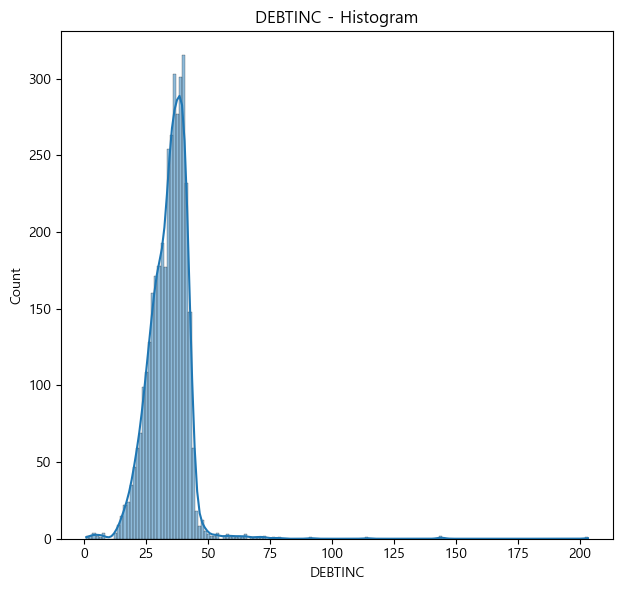

In [12]:
df = df.apply(pd.to_numeric, errors='coerce')

# 히스토그램과 Q-Q 플롯 그리기
for column in df.columns:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'{column} - Histogram')
    
    plt.tight_layout()
    plt.show()

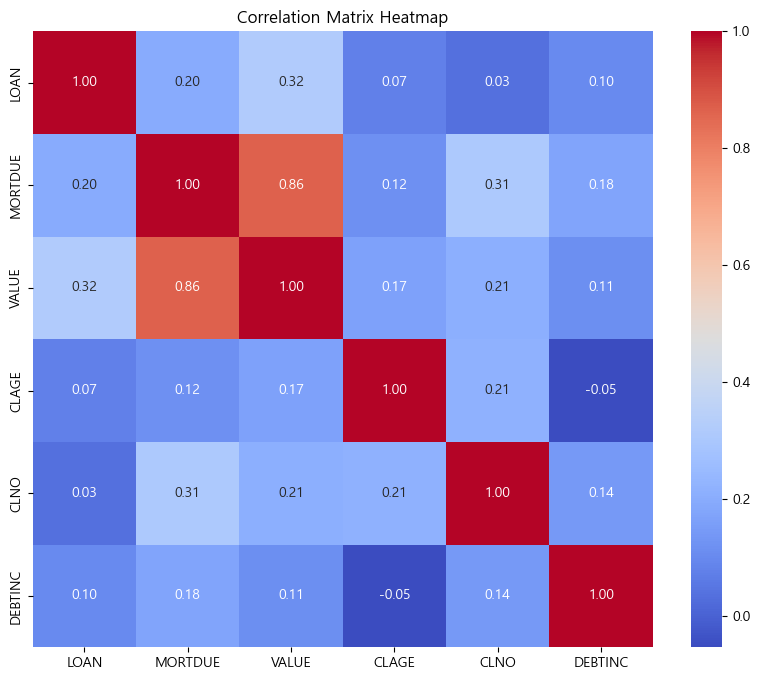

In [13]:
# 필요한 변수들만 선택
selected_columns = ['LOAN', 'MORTDUE', 'VALUE', 'CLAGE', 'CLNO', 'DEBTINC']
df_selected = df[selected_columns]

# 상관관계 행렬 계산
corr_matrix = df_selected.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [19]:
df['VALUE'].fillna(df['VALUE'].median, inplace=True)
df['JOB'].fillna('Other', inplace=True)
df['YOJ'].fillna(df['YOJ'].median, inplace=True)
df['DELINQ'].fillna(df['DELINQ'].median, inplace=True)
df['CLAGE'].fillna(df['CLAGE'].median, inplace=True)
df['NINQ'].fillna(df['NINQ'].median, inplace=True)

In [20]:
df.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

In [26]:
# 대출 상환 여부에 따른 재산 평가 가치 평균 차이
# 귀무가설: 대출 상환 여부에 따라 재산 평가 가치의 평균 차이가 없다. 
# 대립가설: 대출 상환 여부에 따라 재산 평가 가치의 평균 차이가 있다.
if 'BAD' in df.columns and 'VALUE' in df.columns:
    group1 = df[df['BAD'] == 0]['VALUE'].dropna()
    group2 = df[df['BAD'] == 1]['VALUE'].dropna()

    t, p = stats.ttest_ind(group1, group2, equal_var=False)

    print('2-Sample t-test')
    print('t:{}'.format(t))
    print('p:{}'.format(p))
#결론: 대출 상환 여부에 따라 재산 평가 가치의 평균 차이가 없다
# >> 재산 평가 가치에 따라 대출 우대 조건을 조절을 고려해보려 했지만 의미 없음

2-Sample t-test
t:1.0720347483980024
p:0.2843892947275586


In [28]:
# 등분산성
bartlett_test = stats.bartlett(group1, group2)
print('Bartlett\'s Test')
print('Statistic:', bartlett_test.statistic)
print('p-value:', bartlett_test.pvalue)

Bartlett's Test
Statistic: 18.134506896659435
p-value: 2.0583730457145914e-05


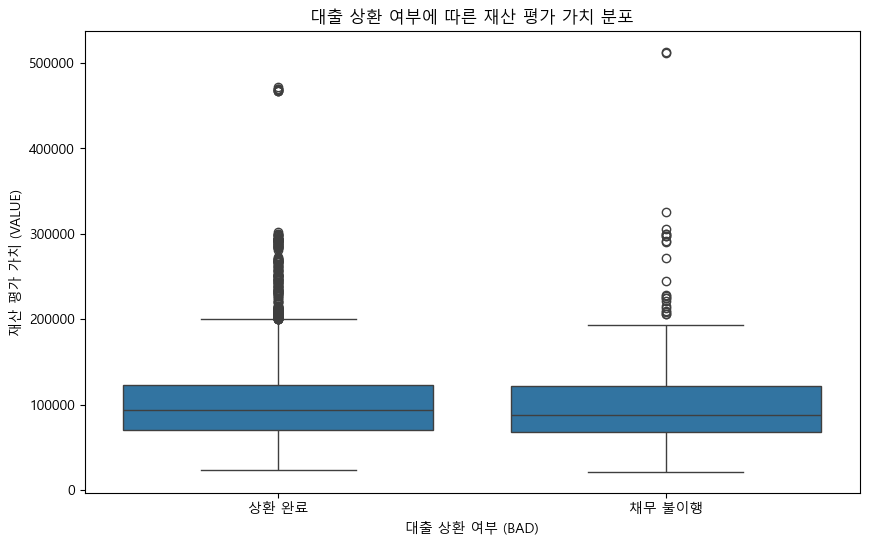

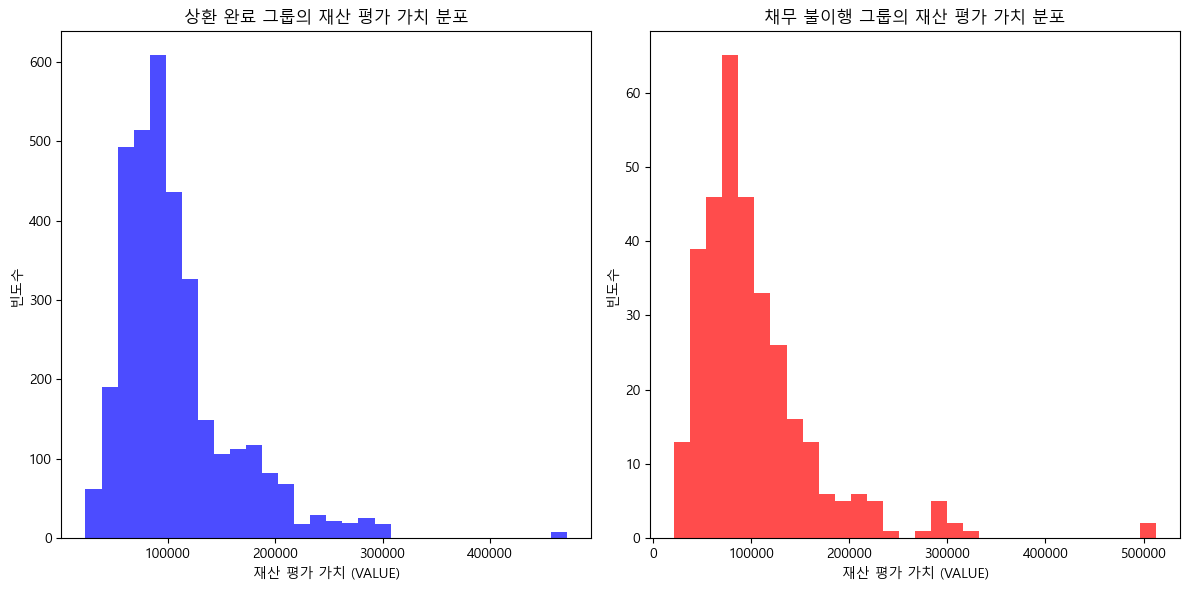

In [29]:
# 박스 플롯(Box Plot) 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='BAD', y='VALUE', data=df)
plt.title('대출 상환 여부에 따른 재산 평가 가치 분포')
plt.xlabel('대출 상환 여부 (BAD)')
plt.ylabel('재산 평가 가치 (VALUE)')
plt.xticks([0, 1], ['상환 완료', '채무 불이행'])
plt.show()

# 히스토그램(Histogram) 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(group1, bins=30, alpha=0.7, color='blue', label='상환 완료')
plt.title('상환 완료 그룹의 재산 평가 가치 분포')
plt.xlabel('재산 평가 가치 (VALUE)')
plt.ylabel('빈도수')

plt.subplot(1, 2, 2)
plt.hist(group2, bins=30, alpha=0.7, color='red', label='채무 불이행')
plt.title('채무 불이행 그룹의 재산 평가 가치 분포')
plt.xlabel('재산 평가 가치 (VALUE)')
plt.ylabel('빈도수')

plt.tight_layout()
plt.show()

In [86]:
# 대출 상환 여부에 따른 부채 소득 비율 차이 분석
# 귀무가설: 대출 상환 여부에 따른 부채 비율 차이가 없다
# 대립가설: 대출 상환 여부에 따른 부채 비율 차이가 있다
if 'BAD' in df.columns and 'DEBTINC' in df.columns:
    group1 = df[df['BAD'] == 0]['DEBTINC'].dropna()
    group2 = df[df['BAD'] == 1]['DEBTINC'].dropna()

    t, p = stats.ttest_ind(group1, group2, equal_var = False)

    print('2-Sample t-test')
    print('t:{}'.format(t))
    print('p:{}'.format(p))
# 결론: 대출 상환 여부에 따른 부채 비율 차이가 있다
# 채무 불이행을 하는 경우 소득이 낮은 그룹이다

2-Sample t-test
t:-6.677949760418371
p:9.379516620089324e-11


In [87]:
# 등분산성
bartlett_test = stats.bartlett(group1, group2)
print('Bartlett\'s Test')
print('Statistic:', bartlett_test.statistic)
print('p-value:', bartlett_test.pvalue)

Bartlett's Test
Statistic: 916.3355000730879
p-value: 2.7587637940426846e-201


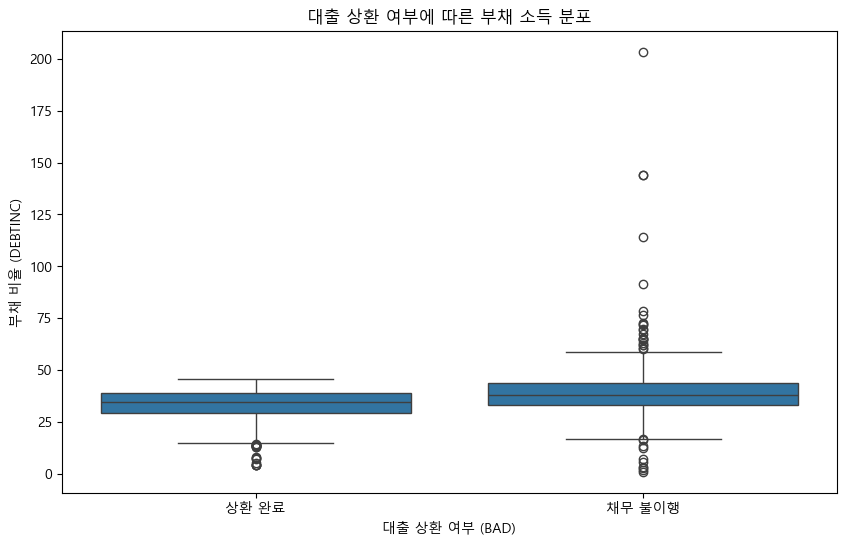

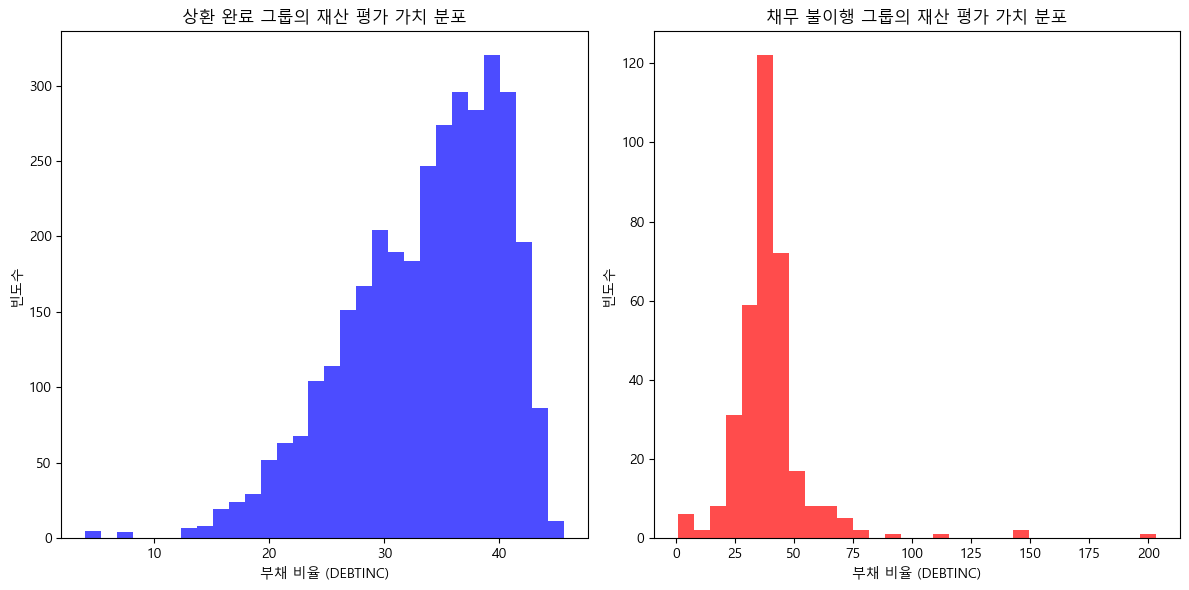

In [88]:
# 박스 플롯(Box Plot) 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='BAD', y='DEBTINC', data=df)
plt.title('대출 상환 여부에 따른 부채 소득 분포')
plt.xlabel('대출 상환 여부 (BAD)')
plt.ylabel('부채 비율 (DEBTINC)')
plt.xticks([0, 1], ['상환 완료', '채무 불이행'])
plt.show()

# 히스토그램(Histogram) 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(group1, bins=30, alpha=0.7, color='blue', label='상환 완료')
plt.title('상환 완료 그룹의 재산 평가 가치 분포')
plt.xlabel('부채 비율 (DEBTINC)')
plt.ylabel('빈도수')

plt.subplot(1, 2, 2)
plt.hist(group2, bins=30, alpha=0.7, color='red', label='채무 불이행')
plt.title('채무 불이행 그룹의 재산 평가 가치 분포')
plt.xlabel('부채 비율 (DEBTINC)')
plt.ylabel('빈도수')

plt.tight_layout()
plt.show()

In [33]:
# 대출 상환 여부에 따른 담보대출 부채 차이 분석
# 귀무가설: 대출 상환 여부에 따른 담보대출 부채 차이가 없다
# 대립가설: 대출 상환 여부에 따른 담보대출 부채 차이가 있다
if 'BAD' in df.columns and 'MORTDUE' in df.columns:
    group1 = df[df['BAD'] == 0]['MORTDUE'].dropna()
    group2 = df[df['BAD'] == 1]['MORTDUE'].dropna()

    t, p = stats.ttest_ind(group1, group2, equal_var = False)
    
    print('2-Sample t-test')
    print('t:{}'.format(t))
    print('p:{}'.format(p))
# 결론: 대출 상환 여부에 따른 담보대출 부채 차이가 없다.

2-Sample t-test
t:0.23365928443674427
p:0.8153689934447139


In [34]:
# 등분산성
bartlett_test = stats.bartlett(group1, group2)
print('Bartlett\'s Test')
print('Statistic:', bartlett_test.statistic)
print('p-value:', bartlett_test.pvalue)

Bartlett's Test
Statistic: 10.561837359572234
p-value: 0.001154463861127612


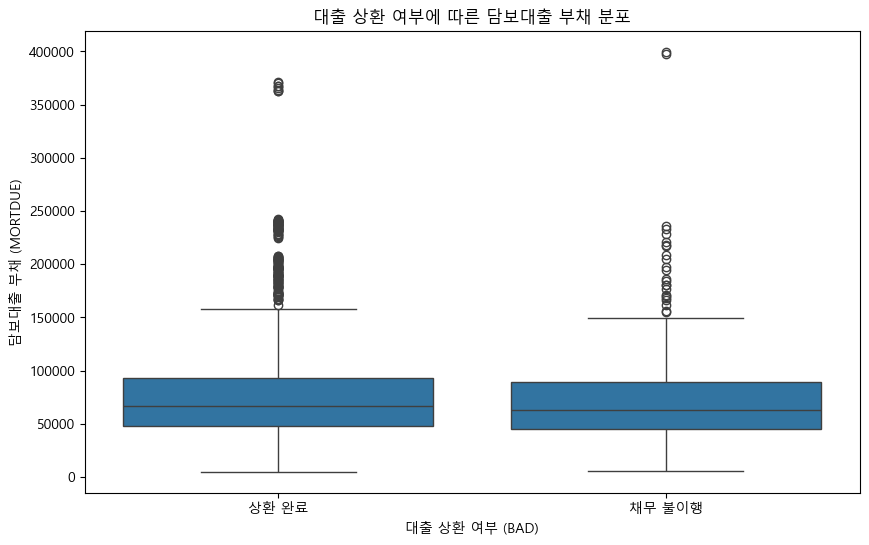

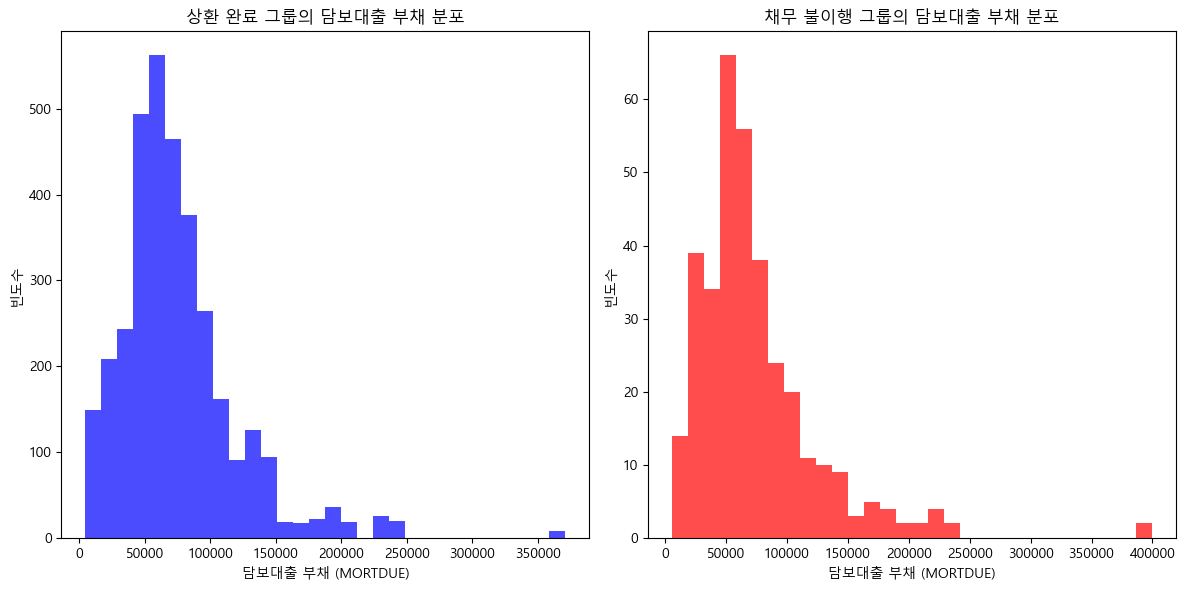

In [35]:
# 박스 플롯(Box Plot) 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='BAD', y='MORTDUE', data=df)
plt.title('대출 상환 여부에 따른 담보대출 부채 분포')
plt.xlabel('대출 상환 여부 (BAD)')
plt.ylabel('담보대출 부채 (MORTDUE)')
plt.xticks([0, 1], ['상환 완료', '채무 불이행'])
plt.show()

# 히스토그램(Histogram) 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(group1, bins=30, alpha=0.7, color='blue', label='상환 완료')
plt.title('상환 완료 그룹의 담보대출 부채 분포')
plt.xlabel('담보대출 부채 (MORTDUE)')
plt.ylabel('빈도수')

plt.subplot(1, 2, 2)
plt.hist(group2, bins=30, alpha=0.7, color='red', label='채무 불이행')
plt.title('채무 불이행 그룹의 담보대출 부채 분포')
plt.xlabel('담보대출 부채 (MORTDUE)')
plt.ylabel('빈도수')

plt.tight_layout()
plt.show()

In [36]:
# 대출 상환 여부에 따른 고용 연수 차이 분석
# 귀무가설: 대출 상환 여부에 따른 고용 연수 차이가 없다
# 대립가설: 대출 상환 여부에 따른 고용 연수 차이가 있다
if 'BAD' in df.columns and 'YOJ' in df.columns:
    group1 = df[df['BAD'] == 0]['YOJ'].dropna()
    group2 = df[df['BAD'] == 1]['YOJ'].dropna()

    t, p = stats.ttest_ind(group1, group2,equal_var=False)

    print('2-Sample t-test')
    print('t:{}'.format(t))
    print('p:{}'.format(p))
# 결론: 대출 상환 여부에 따른 고용 연수 차이가 있다
# 고용 연수가 높을 수록 대출 상환 능력이 있다

2-Sample t-test
t:4.498725054434248
p:8.817829754425187e-06


In [37]:
# 등분산성
bartlett_test = stats.bartlett(group1, group2)
print('Bartlett\'s Test')
print('Statistic:', bartlett_test.statistic)
print('p-value:', bartlett_test.pvalue)

Bartlett's Test
Statistic: 13.067614623085484
p-value: 0.00030044551255109796


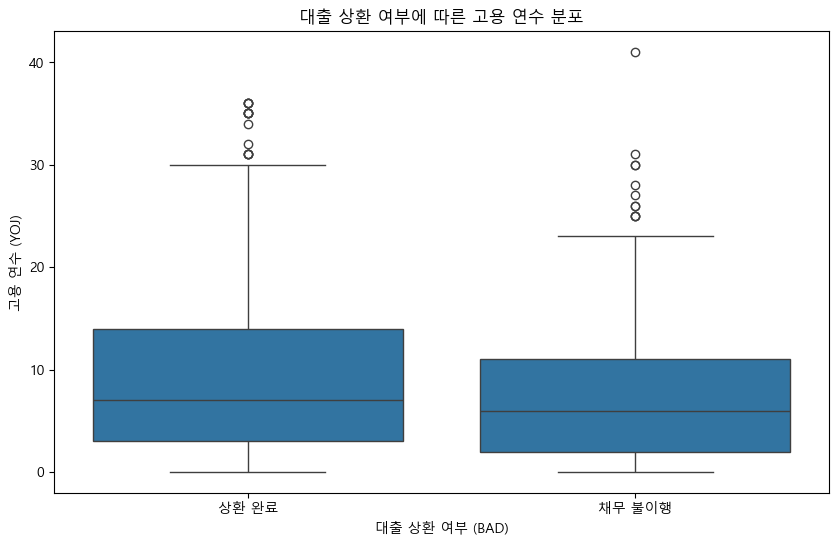

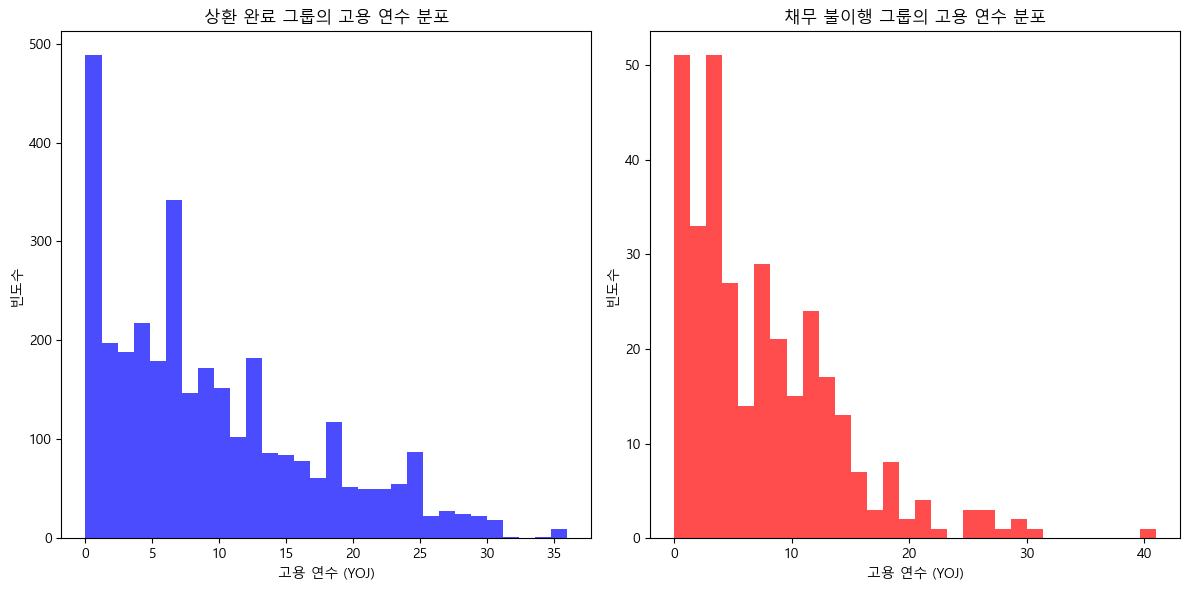

In [38]:
# 박스 플롯(Box Plot) 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='BAD', y='YOJ', data=df)
plt.title('대출 상환 여부에 따른 고용 연수 분포')
plt.xlabel('대출 상환 여부 (BAD)')
plt.ylabel('고용 연수 (YOJ)')
plt.xticks([0, 1], ['상환 완료', '채무 불이행'])
plt.show()

# 히스토그램(Histogram) 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(group1, bins=30, alpha=0.7, color='blue', label='상환 완료')
plt.title('상환 완료 그룹의 고용 연수 분포')
plt.xlabel('고용 연수 (YOJ)')
plt.ylabel('빈도수')

plt.subplot(1, 2, 2)
plt.hist(group2, bins=30, alpha=0.7, color='red', label='채무 불이행')
plt.title('채무 불이행 그룹의 고용 연수 분포')
plt.xlabel('고용 연수 (YOJ)')
plt.ylabel('빈도수')

plt.tight_layout()
plt.show()

In [39]:
# 대출 상환 여부에 따른 부정적인 언급 수 차이 분석
# 귀무가설: 대출 상환 여부에 따른 부정적인 언급 수 차이가 없다
# 대립가설: 대출 상환 여부에 따른 부정적인 언급 수 차이가 있다
if 'BAD' in df.columns and 'DEROG' in df.columns:
    group1 = df[df['BAD'] == 0]['DEROG'].dropna()
    group2 = df[df['BAD'] == 1]['DEROG'].dropna()

    t, p = stats.ttest_ind(group1, group2, equal_var = False)

    print('2-Sample t-test')
    print('t:{}'.format(t))
    print('p:{}'.format(p))
# 대출 상환 여부에 따른 부정적인 언급 수 차이가 있다
# 부정적 언급의 수가 많으면 채무 불이행이 있

2-Sample t-test
t:-6.530184427923162
p:2.3126714705762112e-10


In [40]:
# 등분산성
bartlett_test = stats.bartlett(group1, group2)
print('Bartlett\'s Test')
print('Statistic:', bartlett_test.statistic)
print('p-value:', bartlett_test.pvalue)

Bartlett's Test
Statistic: 1677.4823186607005
p-value: 0.0


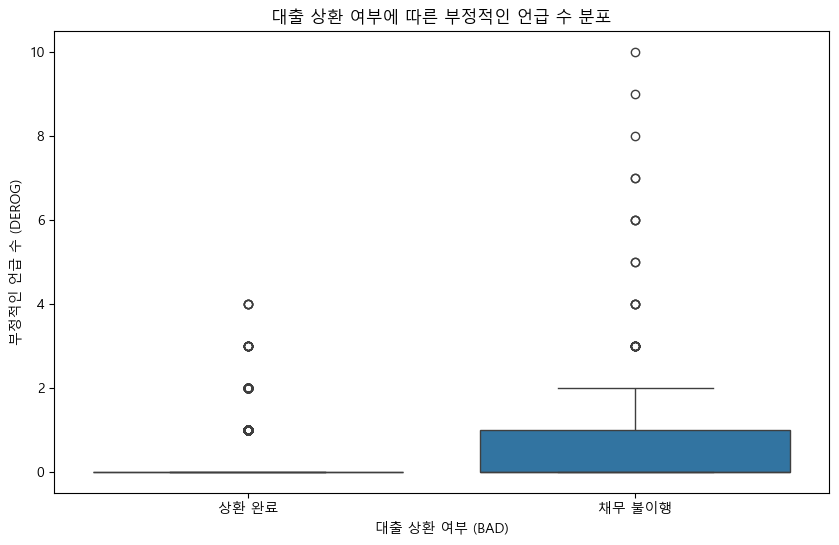

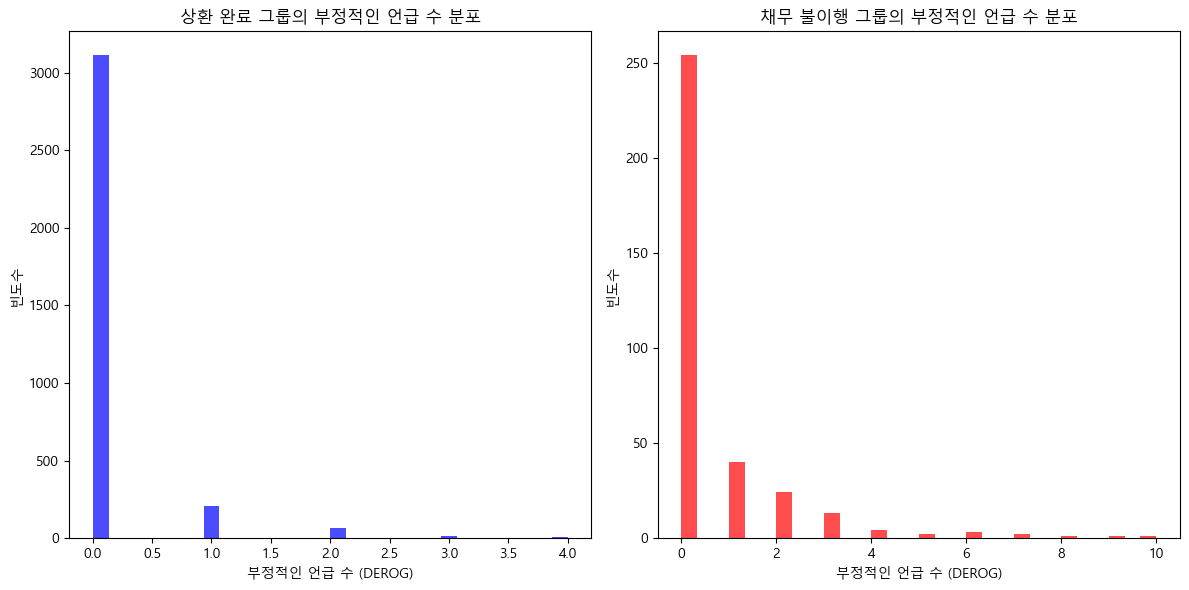

In [41]:
# 박스 플롯(Box Plot) 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='BAD', y='DEROG', data=df)
plt.title('대출 상환 여부에 따른 부정적인 언급 수 분포')
plt.xlabel('대출 상환 여부 (BAD)')
plt.ylabel('부정적인 언급 수 (DEROG)')
plt.xticks([0, 1], ['상환 완료', '채무 불이행'])
plt.show()

# 히스토그램(Histogram) 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(group1, bins=30, alpha=0.7, color='blue', label='상환 완료')
plt.title('상환 완료 그룹의 부정적인 언급 수 분포')
plt.xlabel('부정적인 언급 수 (DEROG)')
plt.ylabel('빈도수')

plt.subplot(1, 2, 2)
plt.hist(group2, bins=30, alpha=0.7, color='red', label='채무 불이행')
plt.title('채무 불이행 그룹의 부정적인 언급 수 분포')
plt.xlabel('부정적인 언급 수 (DEROG)')
plt.ylabel('빈도수')

plt.tight_layout()
plt.show()

In [42]:
# 대출 상환 여부에 따른 신용 한도 점수 평균 차이
# 귀무가설: 대출 상환 여부에 따른 신용 한도 점수 평균 차이가 없다
# 대립가설: 대출 상환 여부에 따른 신용 한도 점수 평균 차이가 있다
if 'BAD' in df.columns and 'CLNO' in df.columns:
    group1 = df[df['BAD'] == 0]['CLNO'].dropna()
    group2 = df[df['BAD'] == 1]['CLNO'].dropna()

    t, p = stats.ttest_ind(group1, group2,equal_var = False)

    print('2-Sample t-test')
    print('t:{}'.format(t))
    print('p:{}'.format(p))
# 결론: 대출 상환 여부에 따른 신용 한도 점수 평균 차이가 없다

2-Sample t-test
t:0.17032581191517154
p:0.8648434126433614


In [43]:
# 등분산성
bartlett_test = stats.bartlett(group1, group2)
print('Bartlett\'s Test')
print('Statistic:', bartlett_test.statistic)
print('p-value:', bartlett_test.pvalue)

Bartlett's Test
Statistic: 56.99613249124823
p-value: 4.3666980643183873e-14


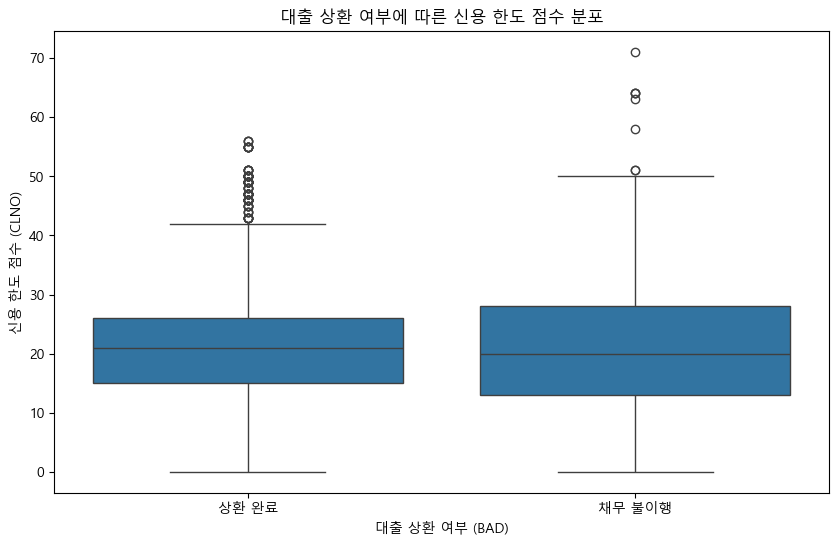

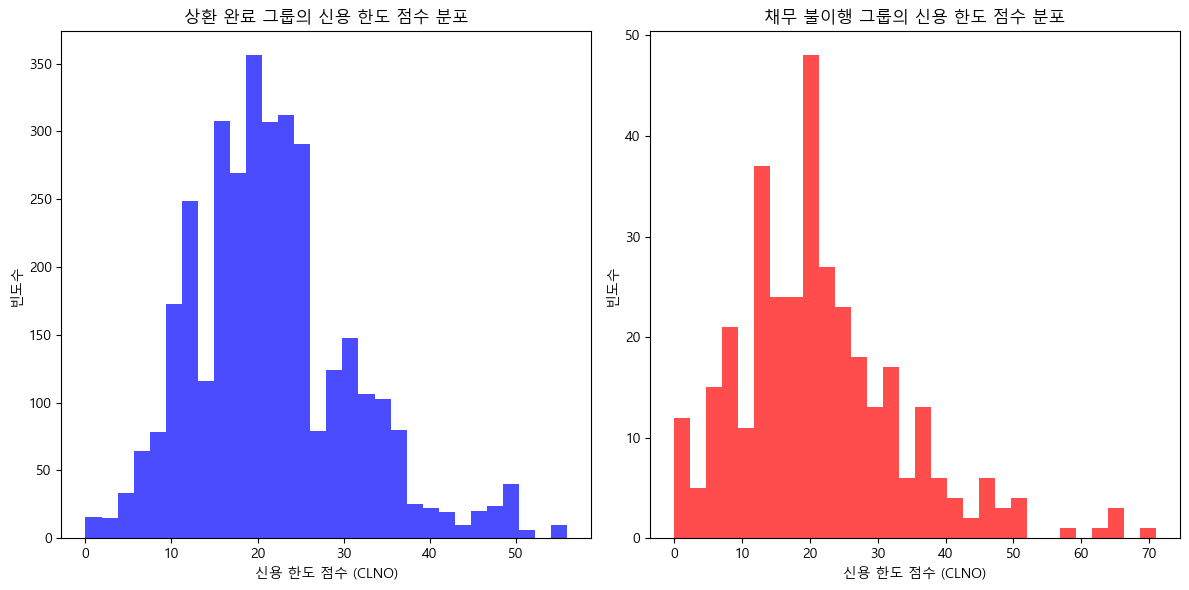

In [44]:
# 박스 플롯(Box Plot) 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='BAD', y='CLNO', data=df)
plt.title('대출 상환 여부에 따른 신용 한도 점수 분포')
plt.xlabel('대출 상환 여부 (BAD)')
plt.ylabel('신용 한도 점수 (CLNO)')
plt.xticks([0, 1], ['상환 완료', '채무 불이행'])
plt.show()

# 히스토그램(Histogram) 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(group1, bins=30, alpha=0.7, color='blue', label='상환 완료')
plt.title('상환 완료 그룹의 신용 한도 점수 분포')
plt.xlabel('신용 한도 점수 (CLNO)')
plt.ylabel('빈도수')

plt.subplot(1, 2, 2)
plt.hist(group2, bins=30, alpha=0.7, color='red', label='채무 불이행')
plt.title('채무 불이행 그룹의 신용 한도 점수 분포')
plt.xlabel('신용 한도 점수 (CLNO)')
plt.ylabel('빈도수')

plt.tight_layout()
plt.show()

In [45]:
df['JOB'].unique()

array(['Other', 'Office', 'Mgr', 'ProfExe', 'Self', 'Sales'], dtype=object)

In [46]:
job_mapping = {
    'Other': 1,
    'Office': 2,
    'Mgr': 3,
    'ProfExe': 4,
    'Self': 5,
    'Sales': 6
}

df['JOB_CODE'] = df['JOB'].map(job_mapping)

In [61]:
# # 직업이나 고용 상태 별 최근 신용한도 평균 차이
# job_codes = df['JOB_CODE'].unique()
# for i in range(len(job_codes)):
#     for j in range(i + 1, len(job_codes)):
#         code1 = job_codes[i]
#         code2 = job_codes[j]
        
#         # 그룹화
#         group1 = df[df['JOB_CODE'] == code1]['CLNO']
#         group2 = df[df['JOB_CODE'] == code2]['CLNO']

#         t, p = stats.ttest_ind(group1, group2)

#         print('2-Sample t-test')
#         print('t:{}'.format(t))
#         print('p:{}'.format(p))
# JOB_CODE 2, 6
# JOB_CODE 3, 6

In [48]:
# 직업이나 고용 상태 별 최근 신용한도 평균 차이
# 귀무가설: office와 sales의 신용한도 차이가 없다
# 대립가설: office와 sales의 신용한도 차이가 있다
if 'JOB_CODE' in df.columns and 'CLNO' in df.columns:
    group1 = df[df['JOB_CODE'] == 2]['CLNO'].dropna()
    group2 = df[df['JOB_CODE'] == 6]['CLNO'].dropna()

    t, p = stats.ttest_ind(group1, group2)

    print('2-Sample t-test')
    print('t:{}'.format(t))
    print('p:{}'.format(p))
# 결론: sales가 신용한도가 office보다 높다

2-Sample t-test
t:-2.144254488159032
p:0.03236376410307525


In [160]:
# 등분산성
bartlett_test = stats.bartlett(group1, group2)
print('Bartlett\'s Test')
print('Statistic:', bartlett_test.statistic)
print('p-value:', bartlett_test.pvalue)

Bartlett's Test
Statistic: 1.976903147036856
p-value: 0.1597170342834072


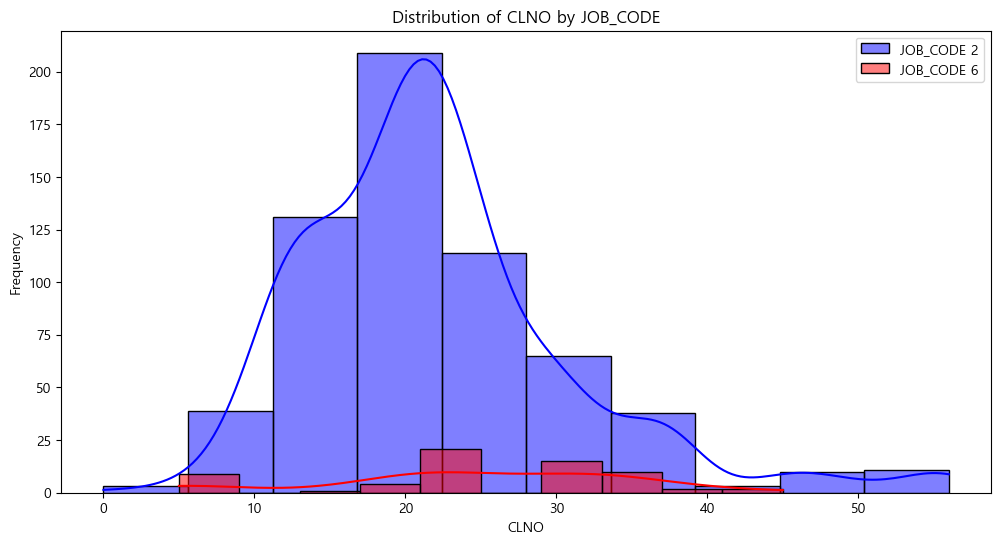

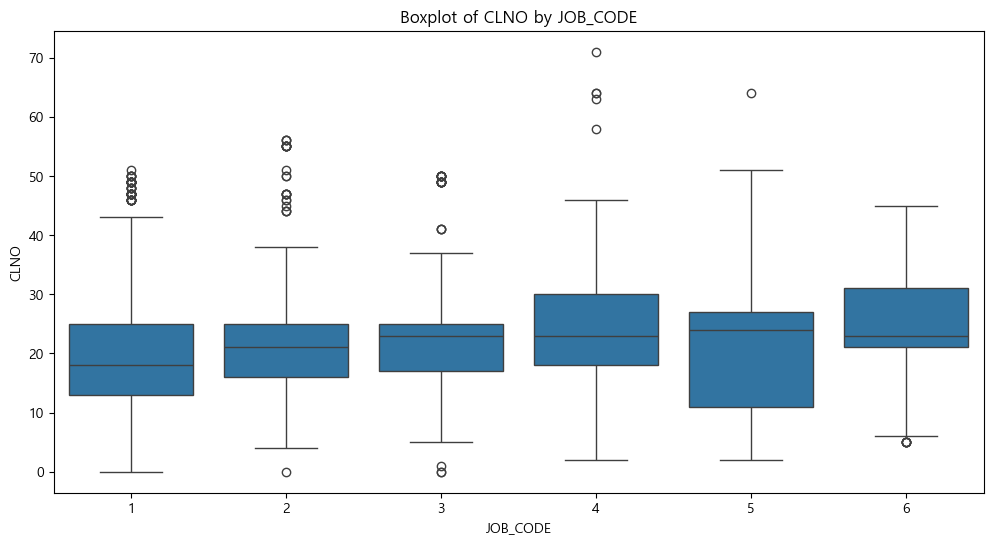

In [162]:
# 히스토그램
plt.figure(figsize=(12, 6))
sns.histplot(group1, kde=True, color='blue', label='JOB_CODE 2', bins=10)
sns.histplot(group2, kde=True, color='red', label='JOB_CODE 6', bins=10)
plt.legend()
plt.title('Distribution of CLNO by JOB_CODE')
plt.xlabel('CLNO')
plt.ylabel('Frequency')
plt.show()

# 박스플롯
plt.figure(figsize=(12, 6))
sns.boxplot(x='JOB_CODE', y='CLNO', data=df)
plt.title('Boxplot of CLNO by JOB_CODE')
plt.xlabel('JOB_CODE')
plt.ylabel('CLNO')
plt.show()

In [167]:
# 직업이나 고용 상태 별 최근 신용한도 평균 차이
if 'JOB_CODE' in df.columns and 'CLNO' in df.columns:
    group1 = df[df['JOB_CODE'] == 3]['CLNO'].dropna()
    group2 = df[df['JOB_CODE'] == 6]['CLNO'].dropna()

    t, p = stats.ttest_ind(group1, group2,equal_var=False)

    print('2-Sample t-test')
    print('t:{}'.format(t))
    print('p:{}'.format(p))
# 결론: sales가 mgr 보다 신용한도가 높다
# 신용한도가 

2-Sample t-test
t:-1.8969063810861009
p:0.06170546169092715


In [168]:
# 등분산성
bartlett_test = stats.bartlett(group1, group2)
print('Bartlett\'s Test')
print('Statistic:', bartlett_test.statistic)
print('p-value:', bartlett_test.pvalue)

Bartlett's Test
Statistic: 5.007777071084674
p-value: 0.025233688902363608


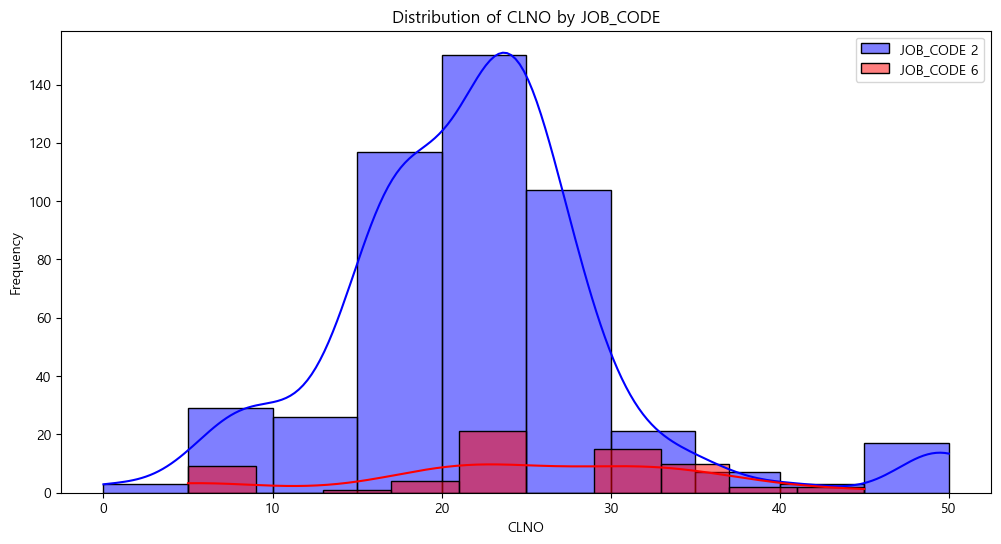

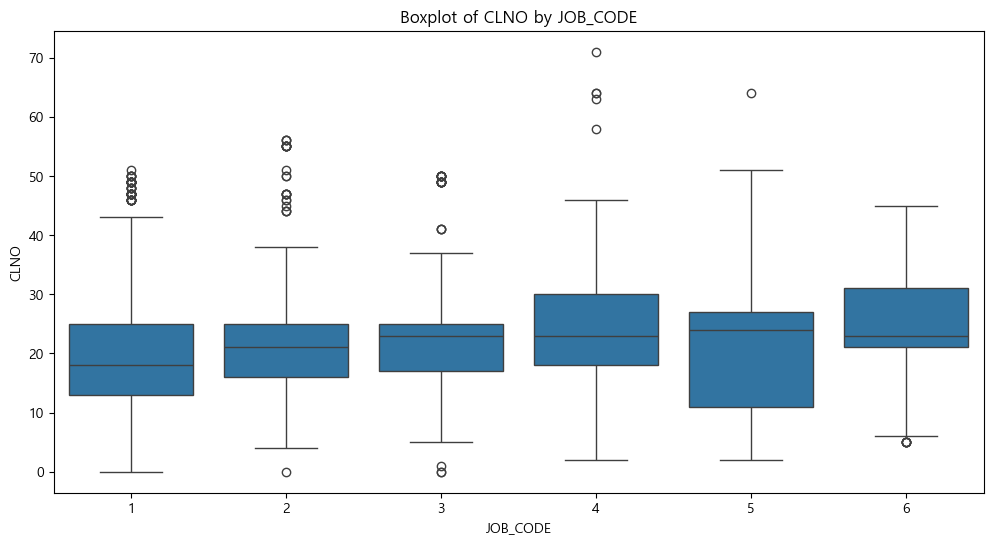

In [165]:
# 히스토그램
plt.figure(figsize=(12, 6))
sns.histplot(group1, kde=True, color='blue', label='JOB_CODE 2', bins=10)
sns.histplot(group2, kde=True, color='red', label='JOB_CODE 6', bins=10)
plt.legend()
plt.title('Distribution of CLNO by JOB_CODE')
plt.xlabel('CLNO')
plt.ylabel('Frequency')
plt.show()

# 박스플롯
plt.figure(figsize=(12, 6))
sns.boxplot(x='JOB_CODE', y='CLNO', data=df)
plt.title('Boxplot of CLNO by JOB_CODE')
plt.xlabel('JOB_CODE')
plt.ylabel('CLNO')
plt.show()

In [51]:
# 고용 연수 구간화
df['YOJ_di'] = pd.cut(df['YOJ'], bins=[0, 6, 16, 41], labels = ['YOJ_1', 'YOJ_2', 'YOJ_3'])
df['YOJ_di'].value_counts()
# 고용된 연수 구간화
df['YOJ_di'].dropna()
df['YOJ_di'] = pd.cut(df['YOJ'], bins=[0, 6, 16, 41], labels = ['YOJ_1', 'YOJ_2', 'YOJ_3'])
df['YOJ_di'].value_counts()

YOJ_di
YOJ_1    1332
YOJ_2    1278
YOJ_3     626
Name: count, dtype: int64

In [58]:
# 고용 연수 별 재산 평균 차이
# 귀무가설: 고용 연수 별 재산 평균 차이가 없다
# 대립가설: 고용 연수 별 재산 평균 차이가 있다
if 'YOJ_di' in df.columns and 'VALUE' in df.columns:
    group1 = df[df['YOJ_di'] == 'YOJ_1']['VALUE'].dropna()
    group2 = df[df['YOJ_di'] == 'YOJ_3']['VALUE'].dropna()

    t, p = stats.ttest_ind(group1, group2)

    print('2-Sample t-test')
    print('t:{}'.format(t))
    print('p:{}'.format(p))
# 고용 연수 별 차이가 있다
# YOJ_2
# YOJ_2가 가장 높다 > 7 - 16 년차가 재산이 가장 많다 > 7 - 16 년차에게 대출을 우대

2-Sample t-test
t:3.40531085352223
p:0.0006743013701343116


In [59]:
# 등분산성
bartlett_test = stats.bartlett(group1, group2)
print('Bartlett\'s Test')
print('Statistic:', bartlett_test.statistic)
print('p-value:', bartlett_test.pvalue)

Bartlett's Test
Statistic: 32.038430670552685
p-value: 1.5115258878337667e-08


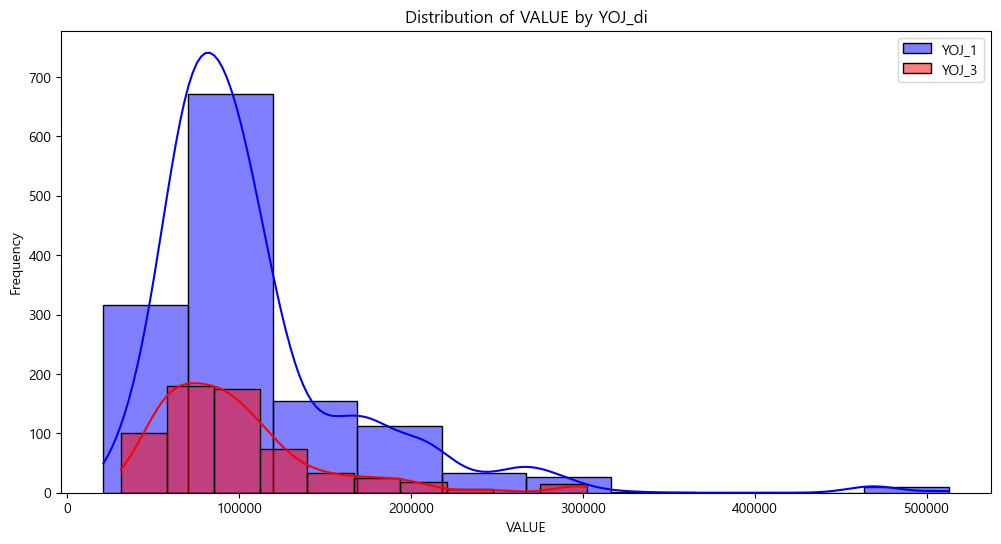

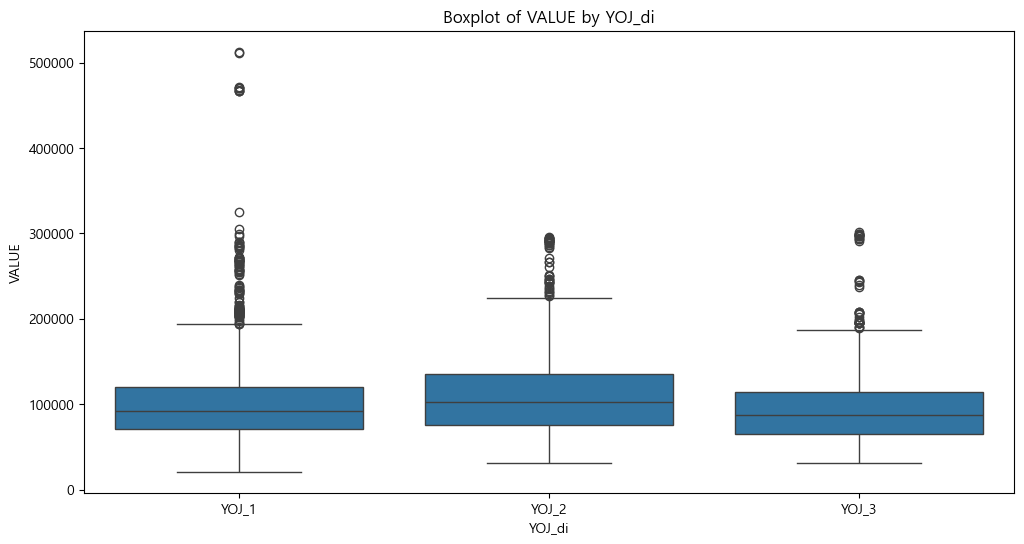

In [60]:
# 히스토그램
plt.figure(figsize=(12, 6))
sns.histplot(group1, kde=True, color='blue', label='YOJ_1', bins=10)
sns.histplot(group2, kde=True, color='red', label='YOJ_3', bins=10)
plt.legend()
plt.title('Distribution of VALUE by YOJ_di')
plt.xlabel('VALUE')
plt.ylabel('Frequency')
plt.show()

# 박스플롯
plt.figure(figsize=(12, 6))
sns.boxplot(x='YOJ_di', y='VALUE', data=df)
plt.title('Boxplot of VALUE by YOJ_di')
plt.xlabel('YOJ_di')
plt.ylabel('VALUE')
plt.show()

In [ ]:
# 대출 목적 별 부채비율 평균 차이 검정

In [83]:
# 신용한도 점수에 따라 대출 가능 금액의 차이-신용한도 사용 비율 파생변수생성
# 가설 검정 추가 : 대출금액(LOAN) /신용한도점수(CLNO) 
# => 신용한도 사용비율(신용한도점수 대비 대출을 얼마나 하였는가,
# 신용한도 점수에 따라 대출가능 금액이 달라짐) 파생변수 생성
# 검정방법 : 신용한도 사용비율(연속형)과 BAD(범주형)을 2 sample t-test로 가설검정
df['LN/CL'] = df['LOAN'] / df['CLNO']
group1 = df[df['BAD'] == 0]['LN/CL'].dropna()
group2 = df[df['BAD'] == 1]['LN/CL'].dropna()

# 2-sample t-test 수행
t, p = stats.ttest_ind(group1, group2, nan_policy = 'omit')

print('2-Sample t-test')
print('t:{}'.format(t))
print('p:{}'.format(p))

2-Sample t-test
t:nan
p:nan


In [76]:
# 등분산성
bartlett_test = stats.bartlett(group1, group2)
print('Bartlett\'s Test')
print('Statistic:', bartlett_test.statistic)
print('p-value:', bartlett_test.pvalue)

Bartlett's Test
Statistic: nan
p-value: nan
